# GNN for Optimal Generation Dispatch
## IEEE 24-bus RTS system 
* System settings: 24 buses, 34 lines (concatenated from 38), 17 loads, 12 generating units on 10 buses.
* Data: Currently we use a dataset with ~ 6000 samples, 80% used for training and 20% for validation.

Step 1: Creating a graph in DGL
-------------------------------
* Load necessary packages.
* Read the data and create the graph for the system:


In [1]:
# Check module 'dgl' is installed, if not, install the module
import sys
import subprocess
import pkg_resources

required = {'dgl'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

# !pip install dgl

In [3]:
# Import necessary packages
import dgl # graph convolution
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from dgl.nn.pytorch.conv import GraphConv

In [4]:
# Load the data files

## @ G-drive env
# from google.colab import drive
# drive.mount('/content/drive')
# filename = './drive/My Drive/Colab Notebooks/ieee24_rts_6183exact_0831.txt' # active level 0.1024(line0.0124), max active line 3

## @ Local env
filename = '../data/ieee24_rts_6183exact_0831.txt' # active level 0.1024(line0.0124), max active line 3

data = pd.read_table(filename,sep=',',header=None).to_numpy()

# system size
n_bus  = int(data[0,0].copy())
n_line  = int(data[1,0].copy())
n_load  = int(data[2,0].copy())
n_sample  = int(data[3,0].copy())

# line connection
line_bus = data[:,1:3].copy()

# load and corresponding line data
load_data0 = data[:,3:n_sample+3].copy()
line_flow = data[:,n_sample + 3 : 2*n_sample + 3].copy()
bound_idx_low = data[:,2*n_sample + 3 : 3*n_sample + 3].copy()
bound_idx_up = data[:,3*n_sample + 3 : 4*n_sample + 3].copy()
bound_idx0 = bound_idx_up + bound_idx_low # may use 'np.add(a,-b)' instead
line_limit = data[:,4*n_sample + 3].copy()
# print(line_limit)

# generation data
gen_exact = data[:,4*n_sample + 4 : 5*n_sample + 4].copy()
gen_low_limit = data[:,5*n_sample + 4].copy()
gen_up_limit = data[:,5*n_sample + 5].copy()

# normalize the generation data
y0 = np.zeros((n_bus,n_sample))
for i in range(n_sample):
  # y0[:,i] = np.divide(line_flow[:,i],line_limit) # w/ direction
  for j in range(n_bus):
    if gen_up_limit[j] > 0:
      y0[j,i] = np.divide(gen_exact[j,i]-gen_low_limit[j],gen_up_limit[j]-gen_low_limit[j])
    else:
      y0[j,i] = 0

  

# % exact generation
# data1(1:N,4*n+5:5*n+4) = gen_data;
# % generation lower bound & upper bound
# data1(1:N,5*n+5) = g_min;
# data1(1:N,5*n+6) = g_max;


In [5]:
print(np.max(y0)) # check the normalization
print(np.min(y0))

1.0
0.0


In [6]:
# Use partial data for faster test
n_sample = 6000

load_data = load_data0[:,:n_sample].copy()
bound_idx = bound_idx0[:,:n_sample].copy()*1

# gen_idx_low = gen_idx_low[:,:n_sample]
# gen_idx_up = gen_idx_up[:,:n_sample]
# gen_idx = gen_idx_up + gen_idx_low

# print system info
print('Test case: ',filename)
print('Number of buses: ',n_bus)
print('Number of lines: ',n_line)
print('Number of loads: ',n_load)
print('Number of samples: ',n_sample)

Test case:  ../data/ieee24_rts_6183exact_0831.txt
Number of buses:  24
Number of lines:  34
Number of loads:  17
Number of samples:  6000


* Generate and visualize the DGL graph

In [7]:
# Graph generating function
def build_system_graph(src,dst):
    # Edges are directional in DGL; Make them bi-directional.
    # Matlab counts from 1 and python from 0
    u = np.concatenate([src, dst])-1 
    v = np.concatenate([dst, src])-1
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

In [8]:
line_src = line_bus[:,0].copy().astype(int)
line_dst = line_bus[:,1].copy().astype(int)
G = build_system_graph(line_src,line_dst)
print('There are %d nodes.' % G.number_of_nodes())
print('There are %d edges.' % G.number_of_edges())

import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
# nx_G = G.to_networkx().to_undirected()
# # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
# pos = nx.kamada_kawai_layout(nx_G)
# nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

There are 24 nodes.
There are 68 edges.


/Users/jeehyunpark/anaconda3/envs/GNN4OPF/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


Step 2: Assign features to nodes, edges
--------------------------------------------
e.g.: Graph neural networks associate features with nodes and edges for training.

* In our case, inputs on nodes, features on egdes


In [9]:
# # In DGL, you can add features for all nodes at once, using a feature tensor that
# # batches node features along the first dimension. The code below adds the learnable
# # embeddings for all nodes:

# embed_feature = 10
# embed = nn.Embedding(G.number_of_edges(), embed_feature)  
# # 68 edges with embedding dim equal to 10 for edge classification
# G.edata['feat'] = embed.weight

Step 3: Define a Graph Convolutional Network (GCN) and Train the model
--------------------------------------------------
To perform node classification, use the Graph Convolutional Network
(GCN) developed by `Kipf and Welling <https://arxiv.org/abs/1609.02907>`_. Here
is the simplest definition of a GCN framework. We recommend that you 
read the original paper for more details.

- At layer $l$, each node $v_i^l$ carries a feature vector $h_i^l$.
- Each layer of the GCN tries to aggregate the features from $u_i^{l}$ where
  $u_i$'s are neighborhood nodes to $v$ into the next layer representation at
  $v_i^{l+1}$. This is followed by an affine transformation with some
  non-linearity.

 **In this project we use weighted graph convolution and weights are 
learned during the trainning process.**

The above definition of GCN fits into a **message-passing** paradigm: Each
node will update its own feature with information sent from neighboring
nodes. A graphical demonstration is displayed below.


In DGL, we provide implementations of popular Graph Neural Network layers under
the `dgl.<backend>.nn` subpackage. The :class:`~dgl.nn.pytorch.GraphConv` module
implements one Graph Convolutional layer.

**In our case, we want to perform edge classification based on feature inputs from nodes.**
* Thus we need to redesign the GNN to map the features from node to deges
* Define a deeper GCN model that contains two GCN layers:

We first try convolutions on the nodes first then map to edges then try mapping to edges first then do convolutions on edges

In [10]:
# One layer Graph convolution from nodes to edges
class Graph_convolution_v2e(nn.Module):
    def __init__(self,in_features,out_features,W,bias=True):
        super(Graph_convolution_v2e,self).__init__()
#         self.Weight=nn.Parameter(torch.Tensor(W))
#         self.Weight=nn.Parameter(torch.from_numpy(W))
        self.register_buffer('w',torch.from_numpy(W).float())
#         for temp in self.Weight:
#             temp.requires_grad=False
#         self.Weight = self.Weight.detach()
        self.scale=nn.Parameter(torch.Tensor(out_features,1))
        self.bias=nn.Parameter(torch.Tensor(out_features,1))
    
    def forward(self,input):
        # print(input.shape)
        # print(self.scale.shape)  
        h = torch.matmul(Variable(self.w),input) 
        return torch.mul(h,self.scale) + self.bias   

# Need to change that to our case: 2 networks, one node clustering (or double it as in the reference), 
# one node to edge.

# Set dummy bus signals as zero
I_bus = np.identity(n_bus)
idx = [2,3,4,5,7,8,9,10,11,16,18,19,23]
for i in range(len(idx)):
  I_bus[idx,idx] = 0
I_bus = torch.from_numpy(I_bus).float()

# GNN using DGL v2v graph convolution and our own v2e graph convolution
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_nodes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size[0],norm='both', weight=True, bias=True, activation=None) 
        #norm='both', weight=True, bias=True, activation=None
        self.conv2 = GraphConv(hidden_size[0], hidden_size[1],norm='both', weight=True, bias=True, activation=None)
        self.conv3 = GraphConv(hidden_size[1], hidden_size[2],norm='both', weight=True, bias=True, activation=None)
        self.conv4 = GraphConv(hidden_size[2], hidden_size[3],norm='both', weight=True, bias=True, activation=None)
        self.conv5 = GraphConv(hidden_size[3], hidden_size[4],norm='both', weight=True, bias=True, activation=None)
        self.conv6 = GraphConv(hidden_size[4], hidden_size[5],norm='both', weight=True, bias=True, activation=None)
        # self.conv7 = GraphConv(hidden_size[5], hidden_size[6],norm='both', weight=True, bias=True, activation=None)
        # self.conv8 = GraphConv(hidden_size[6], hidden_size[7],norm='both', weight=True, bias=True, activation=None)
        # self.conv9 = GraphConv(hidden_size[7], hidden_size[8],norm='both', weight=True, bias=True, activation=None)
        # self.conv3 = Graph_convolution_v2e(hidden_size[1], num_edges, W)
#         self.W = W

        self.lin_output = nn.Linear(num_nodes,num_nodes)

    def forward(self, g, I, inputs): # g is the graph stored in DGL
        # print(g) 
        # nx_G = g.to_networkx().to_undirected()
        # pos = nx.kamada_kawai_layout(nx_G)
        # nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])      
        # print('inputs data type:', inputs.data.type())
        # print(inputs.shape)
        h = self.conv1(g, inputs)
        # h = torch.sigmoid(h)
        # print(h.shape)
        h = self.conv2(g, h)
        # print(h.shape)
        h = torch.sigmoid(h)
        # print(h.shape)
        h = self.conv3(g, h)
        # h = torch.sigmoid(h)
        h = self.conv4(g, h)
        h = torch.sigmoid(h) 
        h = self.conv5(g, h)
        # h = torch.sigmoid(h)
        h = self.conv6(g, h)
        h = torch.sigmoid(h)
        # h = self.conv7(g, h)
        # # h = torch.sigmoid(h)
        # h = self.conv8(g, h)
        # h = torch.sigmoid(h)
        # h = self.conv9(g, h)
        # h = torch.sigmoid(h)
        # h = self.conv3(h)
        # h = torch.matmul(I,h)
        h = self.lin_output(h.transpose(0,1)).transpose(0,1)
        # h = torch.matmul(I,h)
        return h

 
# net = GCN_self(n_bus, [10,10], n_line, W, W1)
# net = GCN(n_bus, [10,10,10,10,10,10,10,1], n_line, W1)
w_params = [40,80,80,80,80,1]
net = GCN(1, w_params, n_bus)

In [11]:
net

GCN(
  (conv1): GraphConv(in=1, out=40, normalization=both, activation=None)
  (conv2): GraphConv(in=40, out=80, normalization=both, activation=None)
  (conv3): GraphConv(in=80, out=80, normalization=both, activation=None)
  (conv4): GraphConv(in=80, out=80, normalization=both, activation=None)
  (conv5): GraphConv(in=80, out=80, normalization=both, activation=None)
  (conv6): GraphConv(in=80, out=1, normalization=both, activation=None)
  (lin_output): Linear(in_features=24, out_features=24, bias=True)
)

In [12]:
# Set the ratio of training/test set
train_ratio = 0.8
n_train = int(np.floor(train_ratio * n_sample))
n_test = n_sample - n_train
print('Data set size: ',n_sample,', training set size: ',n_train,', test set size: ',n_test)

# Generate training set and test set
from sklearn.model_selection import train_test_split
x_train2, x_test2, y_train2, y_test2 = train_test_split(load_data[0:n_bus,:].transpose(), y0[:,0:n_sample].transpose(), test_size=0.2, random_state=22)
x_train = x_train2.transpose()
y_train = y_train2.transpose()
x_test = x_test2.transpose()
y_test = y_test2.transpose()
# x_train = load_data[0:n_bus,0:n_train].copy()
# y_train = bound_idx[:,0:n_train].copy()
# x_test = load_data[0:n_bus,n_train:n_sample].copy()
# y_test = bound_idx[:,n_train:n_sample].copy()


tempx=np.array([np.transpose(x_train)[0]])
x_train_one=torch.from_numpy(tempx).float()
x_train_one=x_train_one.transpose(0,1)
print(x_train_one.shape)


tempy=np.array([np.transpose(y_train)[0]])
y_train_one=torch.from_numpy(tempy).float()
y_train_one=y_train_one.transpose(0,1)
print(y_train_one.shape)
# print('Training data size:',x_train.shape)
# print('Training label size:',y_train.shape)

# get the training data for DGL
def get_xy(index):
    tempx=np.array([np.transpose(x_train)[index]])
    x_train_one=torch.from_numpy(tempx).float()
    x_train_one=x_train_one.transpose(0,1)

    tempy=np.array([np.transpose(y_train)[index]])
    y_train_one=torch.from_numpy(tempy).float()
    y_train_one=y_train_one.transpose(0,1)

    return x_train_one,y_train_one

# generate torch y_train for concatenated obj
y_train1 = torch.from_numpy(y_train)#.float()
# expand into 3d tensor 
y_train1.unsqueeze_(-1)
y_train1 = y_train1.expand(n_bus,n_train,1)
y_train1 = y_train1.transpose(2,1)
print(y_train1.shape)

Data set size:  6000 , training set size:  4800 , test set size:  1200
torch.Size([24, 1])
torch.Size([24, 1])
torch.Size([24, 1, 4800])


In [13]:
# GNN model size
print('Network info:',net)
for temp in net.parameters():
    print('Parameter',temp,'size:',temp.shape)

Network info: GCN(
  (conv1): GraphConv(in=1, out=40, normalization=both, activation=None)
  (conv2): GraphConv(in=40, out=80, normalization=both, activation=None)
  (conv3): GraphConv(in=80, out=80, normalization=both, activation=None)
  (conv4): GraphConv(in=80, out=80, normalization=both, activation=None)
  (conv5): GraphConv(in=80, out=80, normalization=both, activation=None)
  (conv6): GraphConv(in=80, out=1, normalization=both, activation=None)
  (lin_output): Linear(in_features=24, out_features=24, bias=True)
)
Parameter Parameter containing:
tensor([[ 1.6685e-01, -3.3306e-01,  3.4409e-01,  3.3748e-01, -3.7415e-01,
          1.5664e-01,  6.6524e-02,  3.3697e-04, -2.9730e-01,  6.0916e-02,
          4.9961e-02,  3.5847e-02, -3.0070e-01,  3.2523e-01,  1.1745e-01,
          3.1368e-01, -1.6137e-01, -1.4224e-01, -1.4343e-01, -3.5827e-01,
         -9.2137e-02,  4.4945e-03, -3.6912e-01, -3.5111e-01, -1.5674e-01,
          2.3207e-01,  2.3458e-01, -1.4899e-01,  3.5495e-01, -2.3311e-01,


In [15]:
# import itertools
# optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
device = torch.device('cpu')

accumulation_steps = 100
optimizer = torch.optim.Adam(net.parameters())
loss_optm = []
ep_range = 20
for epoch in range(ep_range):
    # print('Epoch:', epoch,'LR:', scheduler.get_lr())
    for sample in range(n_train):
      x_train_one,y_train_one=get_xy(sample)
      net.train()
      logits = net(G, I_bus, x_train_one)
      # loss = F.binary_cross_entropy(torch.sigmoid(logits), y_train_one) #/ accumulation_steps
      # loss = F.mse_loss(torch.sigmoid(logits), y_train_one) #/ accumulation_steps
      loss = F.mse_loss(logits, y_train_one) #/ accumulation_steps
      loss.backward()

      if ((sample+1)%accumulation_steps)==0:
        optimizer.step() # update parameters of net
        optimizer.zero_grad() # clear the psat gradient

  # test for simple adaptive scheme
    # if epoch > 10:
    #   optimizer = torch.optim.Adam(net.parameters(), lr=0.15)
    # if epoch > 10:
    #   optimizer = torch.optim.Adam(net.parameters(), lr=0.04)
    # if epoch > 20:
    #   optimizer = torch.optim.Adam(net.parameters(), lr=0.03)
    # if epoch > 30:
    #   optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
    # if epoch > 40:
    #   optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    # # Decay Learning Rate
    # if epoch > 1:
    #   scheduler.step()
    
    print('Epoch %d | Loss: %.4f' % (epoch + 1, loss.item()))
    loss_optm.append(loss.item())

Epoch 0 | Loss: 0.0080
Epoch 1 | Loss: 0.0080
Epoch 2 | Loss: 0.0080
Epoch 3 | Loss: 0.0080
Epoch 4 | Loss: 0.0080
Epoch 5 | Loss: 0.0080
Epoch 6 | Loss: 0.0080
Epoch 7 | Loss: 0.0080
Epoch 8 | Loss: 0.0080
Epoch 9 | Loss: 0.0080
Epoch 10 | Loss: 0.0080
Epoch 11 | Loss: 0.0080
Epoch 12 | Loss: 0.0080
Epoch 13 | Loss: 0.0080
Epoch 14 | Loss: 0.0080
Epoch 15 | Loss: 0.0081
Epoch 16 | Loss: 0.0079
Epoch 17 | Loss: 0.0080
Epoch 18 | Loss: 0.0080
Epoch 19 | Loss: 0.0080


In [16]:
ep_range1 = 5

for epoch in range(ep_range1):
    # print('Epoch:', epoch,'LR:', scheduler.get_lr())
    for sample in range(n_train):
      x_train_one,y_train_one=get_xy(sample)
      net.train()
      logits = net(G,I_bus, x_train_one)
      # loss = F.binary_cross_entropy(torch.sigmoid(logits), y_train_one) #/ accumulation_steps
      # loss = F.mse_loss(torch.sigmoid(logits), y_train_one) #/ accumulation_steps
      loss = F.mse_loss(logits, y_train_one) #/ accumulation_steps
      loss.backward()

      if ((sample+1)%accumulation_steps)==0:
        optimizer.step() # update parameters of net
        optimizer.zero_grad() # clear the psat gradient

    
    print('Epoch %d | Loss: %.4f' % (epoch+ep_range + 1, loss.item()))
    loss_optm.append(loss.item())

Epoch 20 | Loss: 0.0080
Epoch 21 | Loss: 0.0080
Epoch 22 | Loss: 0.0080
Epoch 23 | Loss: 0.0080
Epoch 24 | Loss: 0.0080


## Optimization methods:
**We need to incorporate batch size into the optimization step size for mini batches.** 
- **Rprop:** A gradient descent algorithm that only uses the signs of gradients to compute updates. It stands for Resilient Propagation and works well in many situations because it adapts the step size dynamically for each weight independently.
- **Learning rate scheduling:** used with optimizers
- **lr_scheduler.StepLR:** Decays the learning rate of each parameter group by gamma every step_size epochs. Notice that such decay can happen simultaneously with other changes to the learning rate from outside this scheduler. When last_epoch=-1, sets initial lr as lr. https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/
- **lr_scheduler.CyclicLR:** Sets the learning rate of each parameter group according to cyclical learning rate policy (CLR). The policy cycles the learning rate between two boundaries with a constant frequency. Cyclical learning rate policy changes the learning rate after every batch. step should be called after a batch has been used for training.

Matplotlib is building the font cache; this may take a moment.


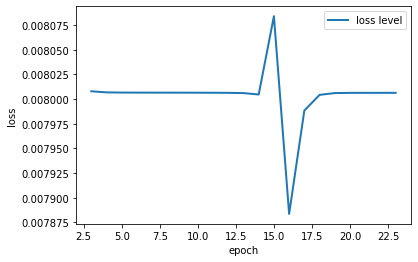

In [17]:
plt.figure()
plot_idx = np.arange(np.size(loss_optm))
plt.plot(plot_idx[3:-1],loss_optm[3:-1],lw=2,label='loss level')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

## Step 4. Validation
**Validate the trained model using the test set**

When a model is trained, we can use the following method to evaluate the performance of the model on the test dataset:

In [18]:
# Generate one data pt. for testing the trained model
def get_xy_test(index):
    tempx=np.array([np.transpose(x_test)[index]])
    x_train_one=torch.from_numpy(tempx).float()
    x_train_one=x_train_one.transpose(0,1)

    tempy=np.array([np.transpose(y_test)[index]])
    y_train_one=torch.from_numpy(tempy).float()
    y_train_one=y_train_one.transpose(0,1)

    return x_train_one,y_train_one

# generate torch y_train for concatenated obj
y_test1 = torch.from_numpy(y_test)#.float()
# expand into 3d tensor 
y_test1.unsqueeze_(-1)
y_test1 = y_test1.expand(n_bus,n_test,1)
y_test1 = y_test1.transpose(2,1)
print(y_test1.shape)

torch.Size([24, 1, 1200])


In [19]:
# model evaluation function
def evaluate(model, g, features, labels, n, I):
    model.eval()
    with torch.no_grad():
      indices = torch.tensor(np.zeros((n_bus,1,n)))
      for sample in range(n):
        x_sample,y_sample=get_xy_test(sample)
        logits = model(g, I, x_sample)
        logp = logits
        # logp = torch.sigmoid(logits)
        # logp = F.log_softmax(logits, 1)
        # _, indices1 = torch.max(logp, dim=1)
        indices[:,:,sample] = logp.clone()

      # correct = torch.sum(indices == labels)
      # return correct.item() * 1.0 / len(labels)
      return indices

In [20]:
print(x_test.shape)
print(y_test1.shape)

(24, 1200)
torch.Size([24, 1, 1200])


In [21]:
# make predictions
indices = evaluate(net, G, x_test, y_test1,n_test, I_bus)
# test_acc = evaluate(net, G, x_test, y_test1,n_test)
# print("Epoch_last {:05d} | Loss {:.4f} | Test Acc {:.4f}".format(epoch, loss.item(), test_acc))

In [22]:
y_test0 = y_test1.numpy().copy()
y_pred0 = indices.numpy().copy()

L_infty_err = []
L1_err = []
for i in range(n_test):
  L_infty_err.append(np.max(np.abs(y_test0[:,:,i]-y_pred0[:,:,i])))
  L1_err.append(np.sum(np.abs(y_test0[:,:,i]-y_pred0[:,:,i])))
print('L_infty mean: ',np.mean(L_infty_err))
print('L_1 mean: ',np.mean(L1_err))
 
val, idx = min((val, idx) for (idx, val) in enumerate(L_infty_err))
print(val,idx)
# print('L_inf sample: \n',y_test[:,:,idx])
# print(y_pred[:,:,idx])
val1, idx1 = min((val, idx) for (idx, val) in enumerate(L1_err))
print(val1,idx1)
# print('L1 sample: \n',y_test[:,:,idx1])
# print(y_pred[:,:,idx1])

L_infty mean:  0.4464177769009668
L_1 mean:  1.3457193668751275
0.1284242598215739 760
0.4439017939160866 97


In [23]:
print(load_data[0:n_bus,:].shape)
print(y0[0:n_bus,0:n_sample].shape)

(24, 6000)
(24, 6000)


In [24]:
# Save the predictions for other training/evaluation jobs


# import pprint
# from os import path
#
# from datetime import datetime
# from packaging import version

def save_dataset(test_case, dataset):
    file_name = test_case.split('.')[0]
    file_path = 'drive/My Drive/gnn/numerical_results/'
    file_dir = file_path + file_name + '.pickle'
    outfile = open(file_dir, 'wb')
    pickle.dump(dataset, outfile)
    outfile.close()

def get_xy_eval(index):
    tempx=np.array([np.transpose(load_data[0:n_bus,:])[index]])
    x_train_one=torch.from_numpy(tempx).float()
    x_train_one=x_train_one.transpose(0,1)

    return x_train_one

def model_eval(model, g, features, n, I):
    model.eval()
    with torch.no_grad():
      indices = torch.tensor(np.zeros((n_bus,1,n)))
      for sample in range(n):
        x_sample=get_xy_eval(sample)
        logits = model(g, I, x_sample)
        logp = logits
        indices[:,:,sample] = logp.clone()

      return indices

indices = model_eval(net, G, load_data[0:n_bus,:], n_sample, I_bus)

In [25]:
# generation prediction by GNN model
print(indices.shape)
gen_pred_norm = indices.numpy().copy()

y0[j,i] = np.divide(gen_exact[j,i]-gen_low_limit[j],gen_up_limit[j]-gen_low_limit[j])

gen_pred = np.zeros((n_bus,n_sample))
for i in range(n_sample):
  for j in range(n_bus):
    gen_pred[j,i] = indices[j,0,i] * (gen_up_limit[j]-gen_low_limit[j]) + gen_low_limit[j]

dataset = {'pred': gen_pred}
# print(dataset)
filename = 'GNN_24bus_gen_prediction_copy_new'
save_dataset(filename, dataset)

torch.Size([24, 1, 6000])


/Users/jeehyunpark/anaconda3/envs/GNN4OPF/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


FileNotFoundError: [Errno 2] No such file or directory: 'drive/My Drive/gnn/numerical_results/GNN_24bus_gen_prediction_copy_new.pickle'

In [ ]:
for i in range(10):
  print(np.sum(x_train[:,i]),np.sum(gen_pred[:,i]))
# print(np.sum(gen_pred[:,1]))

In [ ]:
# Evaluate the prediction accuracy by relative error
acc_threshold1 = 0.05
acc_threshold = 0.1

acc_count = 0
acc_count1 = 0
for i in range(24):
  if np.abs(y_test0[i,:,idx]) > 0:
    if np.abs(y_test0[i,:,idx]-y_pred0[i,:,idx])/np.abs(y_test0[i,:,idx]) < acc_threshold or np.abs(y_test0[i,:,idx]-y_pred0[i,:,idx]) < acc_threshold1:
        acc_count = acc_count+1
    if np.abs(y_test0[i,:,idx1]-y_pred0[i,:,idx1])/np.abs(y_test0[i,:,idx1]) < acc_threshold or np.abs(y_test0[i,:,idx1]-y_pred0[i,:,idx1]) < acc_threshold1:
        acc_count1 = acc_count1+1
  else:
    if np.abs(y_test0[i,:,idx]-y_pred0[i,:,idx]) < acc_threshold1:
        acc_count = acc_count+1
    if np.abs(y_test0[i,:,idx1]-y_pred0[i,:,idx1]) < acc_threshold1:
        acc_count1 = acc_count1+1
print('most accurate L_inf: ',acc_count,'  L_1: ',acc_count1)


acc_test = np.zeros(y_test0.shape[0])
for j in range(y_test0.shape[0]):
  acc_count = 0
  for i in range(24):
    if np.abs(y_test0[i,:,j]) > 0:
      if np.abs(y_test0[i,:,j]-y_pred0[i,:,j])/np.abs(y_test0[i,:,j]) < acc_threshold or np.abs(y_test0[i,:,j]-y_pred0[i,:,j]) < acc_threshold1:
          acc_count = acc_count+1
    else:
      if np.abs(y_test0[i,:,j]-y_pred0[i,:,j]) < acc_threshold1:
          acc_count = acc_count+1
  acc_test[j] = acc_count
print('Mean accuracy: ',np.mean(acc_test)) 

In [ ]:

# for i in range(3):
  # print('Prediction:',indices[:,:,i].transpose(0,1))
  # print('Ture label:',y_test1[:,:,i].transpose(0,1))

## Data visualization

In [ ]:
def result_reshape(data):
    result_dim = math.ceil(math.sqrt(len(data)))
    reshaped_data = np.zeros((result_dim, result_dim))

    for i in range(result_dim):
        for j in range(result_dim):
            try:
                reshaped_data[i][j] = data[result_dim * i + j]
            except IndexError:
                reshaped_data[i][j] = -1
    return reshaped_data


def test_vs_pred(y_test, y_pred,  data_idx, test_case):
    y_test0 = y_test[:,:,data_idx]
    y_pred0 = y_pred[:,:,data_idx]
    y_test_reshaped = result_reshape(y_test0)
    y_pred_reshaped = result_reshape(y_pred0)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    fig.suptitle('Active Constraints Distribution: ' + test_case.split('.')[0], size=19, y=0.88)
    axes[0].set_title('y_test', size=15, y=1.03)
    axes[1].set_title('y_pred', size=15, y=1.03)
    # axes[2].set_title('y_pred_binary', size=15, y=1.03)

    sns.heatmap(y_test_reshaped,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'ticks': [-1, 0, 1], 'shrink': .75},
                square=True,
                ax=axes[0])

    sns.heatmap(y_pred_reshaped,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'ticks': [-1, 0, 1], 'shrink': .75},
                square=True,
                ax=axes[1])
    

    fig.show()
    # file_dir = path.join('drive/My Drive/OPF_Porject_EE394V_SPR2020-master/codes/experiments/figures/', test_case.split('.')[0] + '.png')
    # fig.savefig(file_dir, format='png')

In [ ]:
print(y_test1[:,:,1].transpose(0,1))
print(indices[:,:,1].transpose(0,1))

In [ ]:
# y_test1.resize_((n_bus+n_line,n_test))
# indices_int.resize_((n_bus+n_line,n_test))
# indices.resize_((n_bus+n_line,n_test))

test_cases = [
    'pglib_opf_case24_ieee_rts.pickle', 
]

data_idx = [7,10,33,55,64,78,96]
data_idx = np.arange(10)
# test_vs_pred(y_test, y_pred, data_idx, test_cases[case_idx])
for i in range(len(data_idx)):
  test_vs_pred(y_test1, indices, data_idx[i], test_cases[0])